In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

Read in $\Omega_\mathrm{CIV}$

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/'

In [4]:
data_CIV = np.loadtxt(rootdir + 'omega_c4.dat')

In [5]:
t_med = data_CIV[:,0]
t_hi = data_CIV[:,1]
t_lo = data_CIV[:,2]

In [6]:
Om_med = data_CIV[:,6]
Om_err_lo = data_CIV[:,7]
Om_err_hi = data_CIV[:,8]

In [7]:
Om_med

array([1.15, 0.47, 6.5 , 4.4 , 2.8 , 1.3 , 7.01, 7.23, 2.18, 2.1 , 2.17,
       2.11, 2.15, 1.86, 1.92, 1.61, 1.44, 0.87])

In [8]:
Om_err_lo

array([0.19, 0.12, 0.1 , 1.7 , 0.9 , 0.4 , 2.3 , 2.14, 0.4 , 0.32, 0.28,
       0.24, 0.23, 0.17, 0.17, 0.18, 0.22, 0.13])

In [9]:
Om_err_hi

array([0.22, 0.15, 0.1 , 1.7 , 0.9 , 0.4 , 3.05, 2.65, 0.4 , 0.32, 0.28,
       0.23, 0.23, 0.17, 0.17, 0.18, 0.22, 0.13])

Load cosmology calculator

In [10]:
from astropy.cosmology import FlatLambdaCDM

In [11]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [12]:
from astropy.cosmology import z_at_value
from astropy import units

Convert age of universe values to redshift

In [13]:
z_med = np.zeros(len(t_med))
z_err_lo = np.zeros(len(t_med))
z_err_hi = np.zeros(len(t_med))

for i in range(len(z_med)):
    
    z_med[i] = z_at_value(cosmo.age, t_med[i]*units.Gyr)
    
    if t_hi[i]!=0:
        z_lo = z_at_value(cosmo.age, t_hi[i]*units.Gyr) # Low redshift is large age
        z_hi = z_at_value(cosmo.age, t_lo[i]*units.Gyr)
        
        z_err_lo[i] = z_med[i]-z_lo
        z_err_hi[i] = z_hi-z_med[i]

Now convert redshifts to lookback time

In [14]:
tlb_med = cosmo.lookback_time(z_med).value
tlb_lo = cosmo.lookback_time(z_med-z_err_lo).value # low redshift low lookback
tlb_hi = cosmo.lookback_time(z_med+z_err_hi).value # low redshift low lookback

In [15]:
tlb_err_lo = tlb_med-tlb_lo
tlb_err_hi = tlb_hi-tlb_med

Load in SFRD

In [16]:
data_SFRD = np.loadtxt(rootdir + 'sfrdz.dat')

In [17]:
zSFRD = data_SFRD[:,1]
SFRD = data_SFRD[:,2]

In [18]:
tlb_SFRD = cosmo.lookback_time(zSFRD).value

Make plot

In [19]:
z_med_slice = np.concatenate((z_med[:1],z_med[2:]))
z_err_lo_slice = np.concatenate((z_err_lo[:1],z_err_lo[2:]))
z_err_hi_slice = np.concatenate((z_err_hi[:1],z_err_hi[2:]))

tlb_med_slice = np.concatenate((tlb_med[:1],tlb_med[2:]))
tlb_err_lo_slice = np.concatenate((tlb_err_lo[:1],tlb_err_lo[2:]))
tlb_err_hi_slice = np.concatenate((tlb_err_hi[:1],tlb_err_hi[2:]))

Om_med_slice = np.concatenate((Om_med[:1],Om_med[2:]))
Om_err_lo_slice = np.concatenate((Om_err_lo[:1],Om_err_lo[2:]))
Om_err_hi_slice = np.concatenate((Om_err_hi[:1],Om_err_hi[2:]))

In [20]:
z_ticks = np.array([0, 1, 2, 3, 6 ])
tlb_ticks = cosmo.lookback_time(z_ticks).value

In [21]:
def tlb2z(tlb_arr):
    for tlb in tlb_arr:
        if tlb>0:
            return z_at_value(cosmo.lookback_time, tlb*units.Gyr)
        else:
            return 0

def z2tlb(z_arr):
    for z in z_arr:
        if z>0: 
            return cosmo.lookback_time(z).value
        else:
            return 0

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_8274/2219159456.py:42: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.savefig(rootdir+'SFRD_CIV.pdf', dpi=300)


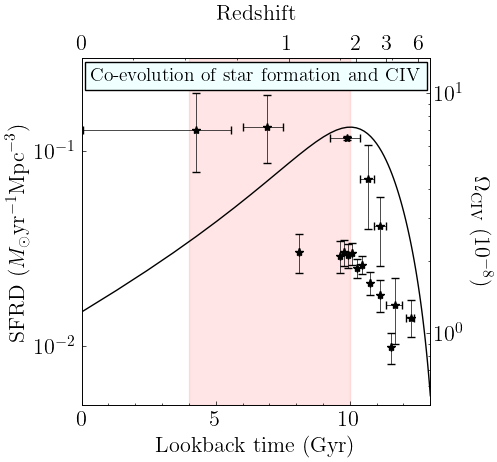

In [82]:
fig, ax = plt.subplots(1, figsize=(4.5,4.5))

# Plot SFRD
ax.plot(tlb_SFRD, data_SFRD[:,2])
ax.set_yscale('log')
ax.set_xlim(0,13)
ax.set_ylim(5e-3, 3e-1)
#ax.tick_params(labeltop='off')

ax.axvspan(4,10, color='red', alpha=.1)
ax.text(0.35, 2.3e-1, 'Co-evolution of star formation and CIV', 
        bbox=dict(facecolor='azure'),
        fontsize=14)


ax.set_xlabel('Lookback time (Gyr)')
ax.set_ylabel('SFRD ($M_\odot \mathrm{yr}^{-1} \mathrm{Mpc}^{-3}$)')

# Plot Omega_CIV
ax2 = ax.twinx()
ax2.errorbar(tlb_med_slice, Om_med_slice, 
             xerr=[tlb_err_lo_slice, tlb_err_hi_slice],
             yerr=[Om_err_lo_slice, Om_err_hi_slice],
             lw=0.5,
             marker='*',linestyle='none', capsize=3)
ax2.set_yscale('log')
#ax2.tick_params(labeltop='off')

ax2.set_ylim(0.5, 14)
ax2.set_ylabel(r'$\Omega_\mathrm{CIV} \ (10^{-8})$', rotation=270, labelpad=20)

# Put redshift
#ax2 = ax.secondary_xaxis("top", functions=(tlb2z,z2tlb))

ax_copy = ax.twiny() # https://stackoverflow.com/questions/10514315/how-to-add-a-second-x-axis-in-matplotlib
ax_copy.set_xlim(ax.get_xlim())
ax_copy.tick_params(labeltop='off')
ax_copy.set_xticks(tlb_ticks)
ax_copy.set_xticklabels(z_ticks)
ax_copy.set_xlabel('Redshift', labelpad=10)

plt.savefig(rootdir+'SFRD_CIV.pdf', dpi=300)